-500 490
(3, 100)


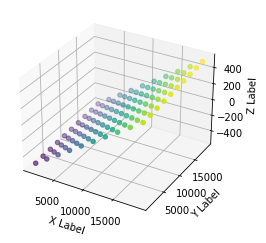

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 9000, 9000, 9000, 9000, 9000, 9000, 9000, 9000, 9000, 9000, 11000, 11000, 11000, 11000, 11000, 11000, 11000, 11000, 11000, 11000, 13000, 13000, 13000, 13000, 13000, 13000, 13000, 13000, 13000, 13000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 17000, 17000, 17000, 17000, 17000, 17000, 17000, 17000, 17000, 17000, 19000, 19000, 19000, 19000, 19000, 19000, 19000, 19000, 19000, 19000]
[1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 1000, 3000, 5000, 7000,

In [1]:
from data.visualise import scatter_3d
import numpy as np
xs = []
ys = []
zs = []
exchanges = []

z = -500
n_repeats = 1
for x in range(1000, 20000, 2000):
    for y in range(1000, 20000, 2000):
        if z <=500:
            for _ in range(n_repeats):
                xs.append(x)
                ys.append(y)
                zs.append(z)
                exchanges.append(1)
            z+=10
print(min(zs), max(zs))
print(np.stack((xs, ys, zs)).shape)
scatter_3d(np.stack((xs, ys, zs)).T)
print(xs)
print(ys)
print(zs)
print(exchanges)

In [2]:
'''
--------
|    x |   <- 50nm deeper than other
|      |
| x    |
--------

5 structures, frame 16 px,
structureX: 1000,3000
structureY: 1000,3000

structure3D: 0,50
ExchangeLabels:1,1
'''

# dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_test/nanopore/NPC-A647-3D-stack_1'

# dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/500nm/500nm'
# dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/50nm/50nm'

# dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/nanopore/nanopore_epfl_50nm'

# true_cluster_count = 1
# dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/grid_single/grid_single'
# true_cluster_count = 2
# dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/grid_pairs/grid_pairs'
# true_cluster_count = 3
# dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/grid_triples/grid_triples_more_frames'

dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/step_grid/step_grid_90nm_pixel'

# tubules
# dirpath = '/home/miguel/Projects/uni/data/smlm_3d/epfl/tubules/low_density/sequence-as-stack-MT0.N1.LD-AS-Exp'

In [3]:
import yaml

yaml_file = f'{dirpath}.yaml'

class SafeLoaderIgnoreUnknown(yaml.SafeLoader):
    def ignore_unknown(self, node):
        return None 

SafeLoaderIgnoreUnknown.add_constructor(None, SafeLoaderIgnoreUnknown.ignore_unknown)

with open(yaml_file, "r") as stream:
    root = yaml.load(stream, Loader=SafeLoaderIgnoreUnknown)
with open(yaml_file, "w") as stream:
    yaml.dump(root, stream)

In [4]:
%load_ext autoreload
%autoreload 2

import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [5,5]

locs = f'{dirpath}_locs.hdf5'
spots = f'{dirpath}_spots.hdf5'
df = pd.read_hdf(locs, 'locs')



f = h5py.File(spots, 'r')
spots = np.array(f['spots'])[:, :, :, np.newaxis]
f.close()
 
# df['id'] = np.arange(0, df.shape[0])
# df = df.loc[(df['x'] > 20) &(df['x'] < 60) & (df['y'] > 20) &(df['y'] < 60)]
# spots = spots[list(df['id'].to_numpy())]

def norm_psfs(psfs):
    psfs_max = psfs.max(axis=(1,2,3))[:, np.newaxis, np.newaxis, np.newaxis]
    psfs_min = psfs.min(axis=(1,2,3))[:, np.newaxis, np.newaxis, np.newaxis]
    return (psfs - psfs_min) / (psfs_max - psfs_min)

print(spots.shape)
n_spots = 100000
spots = spots[:n_spots]
df = df.iloc[:n_spots]
print(spots.shape)
import tensorflow as tf
from skimage.transform import resize

spots = np.stack([resize(img, (32, 32, spots.shape[-1]), anti_aliasing=True) for img in spots])

spots = norm_psfs(spots)
print(spots.min(), spots.max())
print(spots.shape)
print(df.shape)

(65578, 31, 31, 1)
(65578, 31, 31, 1)
0.0 1.0
(65578, 32, 32, 1)
(65578, 12)


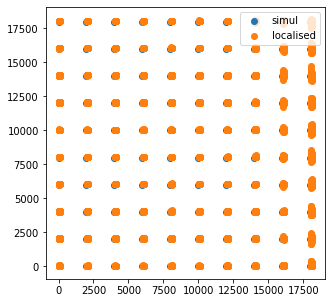

In [5]:
from sklearn.metrics import euclidean_distances

def lookup_z_coord(simul_coords, coord):
    dists = euclidean_distances(simul_coords[:, [0, 1]], [coord])
    min_dist = np.argmin(dists.squeeze())
    return simul_coords[min_dist][-1]
    
simul_coords = np.stack((xs, ys, zs)).T


loc_coords = df[['x', 'y']].to_numpy()*90
loc_coords[:, 1] = -loc_coords[:, 1]
loc_coords[:, 0] -= loc_coords[:, 0].min()
loc_coords[:, 1] -= loc_coords[:, 1].min()

simul_coords[:, 0] -= simul_coords[:, 0].min()
simul_coords[:, 1] -= simul_coords[:, 1].min()

plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(simul_coords[:, 0], simul_coords[:, 1], label='simul')
plt.scatter(loc_coords[:, 0], loc_coords[:, 1], label='localised')
plt.legend()
plt.show()
true_zs = np.array([lookup_z_coord(simul_coords, loc_coords[i]) for i in range(df.shape[0])])

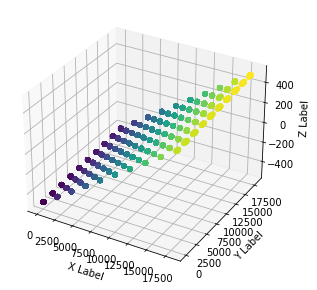

In [6]:
fake_coords = np.concatenate((loc_coords[:, [0, 1]], true_zs[:, np.newaxis]), axis=-1)
plt.rcParams['figure.figsize'] = [5, 5]
scatter_3d(fake_coords)


Rows 6558 Cols 10 n_spaces 65580 n_psfs 65578


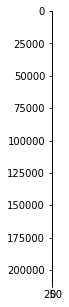

In [7]:
from data.visualise import grid_psfs

plt.imshow(grid_psfs(spots[np.argsort(true_zs)].squeeze()))
plt.rcParams['figure.figsize'] = [500, 200]
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

coords = np.zeros((true_zs.shape[0], 2))
idx = np.arange(0, coords.shape[0])

train_idx, test_idx = train_test_split(idx, train_size=0.8)

train_x, train_y = (spots[train_idx], coords[train_idx]), true_zs[train_idx]
test_x, test_y = (spots[test_idx], coords[test_idx]),true_zs[test_idx]

print(train_x[0].shape, train_x[1].shape, train_y.shape)
print(test_x[0].shape, test_x[1].shape, test_y.shape)

data = {
    'train': (train_x, train_y),
    'val': (test_x, test_y),
}

(52462, 32, 32, 1) (52462, 2) (52462,)
(13116, 32, 32, 1) (13116, 2) (13116,)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 sequential_5 (Sequential)      (None, 512)          21303936    ['input_8[0][0]']                
                                                                                                  
 input_9 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 tf.concat_4 (TFOpLambda)       (None, 514)          0           ['sequential_5[0][0]',           
                                                                  'input_9[0][0]']          


Epoch 80: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 105: ReduceLROnPlateau reducing learning rate to 1e-07.



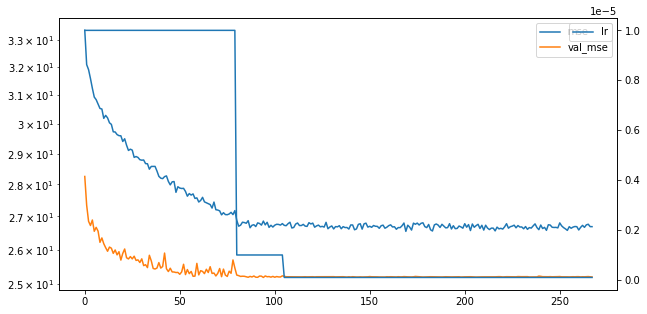

In [9]:
from model.model import get_resnet_101, save_model, train_model, load_trained_model, compile_model, resnet_model

LEARNING_RATE = 1e-5
model = load_trained_model('epfl_picasso_retrain')
model.layers[1].trainable = True
compile_model(model, LEARNING_RATE)
model = train_model(model, data)

In [10]:
save_model(model, 'epfl_picasso_retrain_90nm')

INFO:tensorflow:Assets written to: /home/miguel/Projects/uni/phd/smlm_z/model/trained_models/epfl_picasso_retrain_90nm/assets


INFO:tensorflow:Assets written to: /home/miguel/Projects/uni/phd/smlm_z/model/trained_models/epfl_picasso_retrain_90nm/assets


In [11]:
all_vals_true = []
all_vals_pred = []

In [12]:
from data.visualise import scatter_3d, scatter_yz
plt.rcParams['figure.figsize'] = [15, 15]
zxy = np.concatenate((df[['x', 'y']].to_numpy(), preds[:, np.newaxis]), axis=1)
scatter_3d(zxy)
scatter_yz(zxy)

NameError: name 'preds' is not defined